### 🛠️ Setup & Initialization

In [1]:
# %%capturesdsd

import os
import torch
import warnings
warnings.filterwarnings("ignore")

from transformers import AutoProcessor, GenerationConfig
from modeling_bailingmm import BailingMMNativeForConditionalGeneration

# Load pre-trained model with optimized settings, this will take ~10 minutes
model = BailingMMNativeForConditionalGeneration.from_pretrained(
    "inclusionAI/Ming-Lite-Omni",
    torch_dtype=torch.bfloat16,  # Use bfloat16 for memory efficiency
    attn_implementation="flash_attention_2",
    load_image_gen=True,
    low_cpu_mem_usage=True       # Minimize CPU memory during loading
).to("cuda")                     # Run on GPU

# Initialize processor for handling multimodal inputs
processor = AutoProcessor.from_pretrained(".", trust_remote_code=True)

Notice: ffmpeg is not installed. torchaudio is used to load audio
If you want to use ffmpeg backend to load audio, please install it by:
	sudo apt install ffmpeg # ubuntu
	# brew install ffmpeg # mac


[2025-07-18 17:28:05,077] [INFO] [add_hooks.py:71:__init__] If you are working on AIStudio, please set 'ANTMONITOR_TFEVENT_PATH' env.
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
BailingMoeForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, 

### ⚙️ Inference Pipeline

In [2]:
def generate(messages):
    # 1. Format inputs using chat template
    text = processor.apply_chat_template(messages, add_generation_prompt=True)

    # 2. Extract vision/audio data
    image_inputs, video_inputs, audio_inputs = processor.process_vision_info(messages)

    # 3. Prepare tensor inputs
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        audios=audio_inputs,
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)
    for k in inputs.keys():
        if k == "pixel_values" or k == "pixel_values_videos" or k == "audio_feats":
            inputs[k] = inputs[k].to(dtype=torch.bfloat16)

    # 4. Configure generation
    generation_config = GenerationConfig.from_dict({'no_repeat_ngram_size': 10})
    generated_ids = model.generate(
        **inputs,
        max_new_tokens=8192 * 2,
        use_cache=True,
        eos_token_id=processor.gen_terminator,
        generation_config=generation_config,
    )
    generated_ids_trimmed = [
            out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]

    # 5. Decode output
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0]
    
    return output_text

### 💬 Text QA Example

In [3]:
# qa
messages = [
    {
        "role": "HUMAN",
        "content": [
            {"type": "text", "text": "请详细介绍鹦鹉的生活习性。"}
        ],
    },
]

from IPython.utils import io
with io.capture_output() as captured:
    output_text = generate(messages)

print("请详细介绍鹦鹉的生活习性。\n")
print("Answer:")
print(output_text)

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
2025-07-18 17:29:47,037 - modeling_bailing_moe - WARNING - The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.


请详细介绍鹦鹉的生活习性。

Answer:
鹦鹉是一种非常受欢迎的宠物鸟，以其鲜艳的羽毛、聪明和社交性强的特点而闻名。以下是鹦鹉的一些生活习性：

### 1. **栖息环境**
鹦鹉通常生活在热带和亚热带地区，包括雨林、草原和灌木丛。它们喜欢温暖湿润的环境，但也能够适应一些较为干燥的气候。

### 2. **饮食**
鹦鹉是杂食性动物，主要以种子、果实、花朵、坚果和昆虫为食。不同种类的鹦鹉有不同的饮食偏好。例如，亚马逊鹦鹉喜欢坚果和水果，而长尾小鹦鹉则更喜欢吃种子和蔬菜。

### 3. **社交行为**
鹦鹉是非常社交的动物，通常生活在群体中。它们通过复杂的叫声和肢体语言进行交流。鹦鹉之间的互动非常丰富，包括互相理毛、玩耍和合作觅食。

### 4. **繁殖**
鹦鹉的繁殖季节因种类而异，但通常在春季和夏季。雌性鹦鹉通常会在树洞或岩石缝隙中筑巢，产下2到8枚卵。孵化期约为18到30天，幼鸟在孵化后需要父母的照顾和喂养。

### 5. **寿命**
鹦鹉的寿命因种类而异，一般在10到50年之间。大型鹦鹉如金刚鹦鹉可以活到70年以上，而小型鹦鹉如长尾小鹦鹉的寿命通常在10到20年之间。

### 6. **智力**
鹦鹉是非常聪明的鸟类，具有高度的认知能力和学习能力。它们能够模仿人类的声音，甚至学会简单的词汇和短语。鹦鹉还表现出解决问题的能力和社交技巧。

### 7. **活动时间**
鹦鹉通常在白天活动，尤其是在早晨和傍晚。它们喜欢在阳光下活动，但也需要适当的遮荫和休息。

### 8. **飞行能力**
鹦鹉是强壮的飞行者，能够飞行相当长的距离。它们在飞行中表现出灵活性和耐力，能够在空中进行复杂的动作。

### 9. **领地性**
鹦鹉具有一定的领地性，尤其是在繁殖季节。它们会通过叫声和姿态来宣示领地，保护自己的巢穴和食物来源。

### 10. **适应性**
鹦鹉具有很强的适应性，能够适应不同的生活环境。许多鹦鹉在野外和人类饲养的环境中都能茁壮成长。

总的来说，鹦鹉是一种非常有趣和聪明的鸟类，它们的生活习性丰富多彩，适合那些有足够时间和精力照顾它们的饲养者。


### 🖼️ Image QA Example

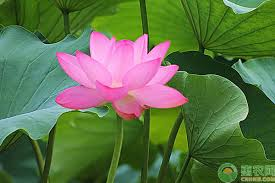

What kind of flower is this?

Answer: This is a lotus flower.


In [4]:

import os

os.environ["TOKENIZERS_PARALLELISM"] = "true"  # Use to suppress warnings

# image qa
messages = [
    {
        "role": "HUMAN",
        "content": [
            {"type": "image", "image": "figures/cases/flower.jpg"},
            {"type": "text", "text": "What kind of flower is this?"},
        ],
    },
]

from IPython.utils import io
with io.capture_output() as captured:  # used to suppress output inside the function
    output_text = generate(messages)

from IPython.display import display, Image
display(Image("figures/cases/flower.jpg"))
print("What kind of flower is this?\n")
print(f"Answer: {output_text}")

### 🤔 Chain-of-Thought Reasoning
**To enable thinking before response, adding the following system prompt before your question:**

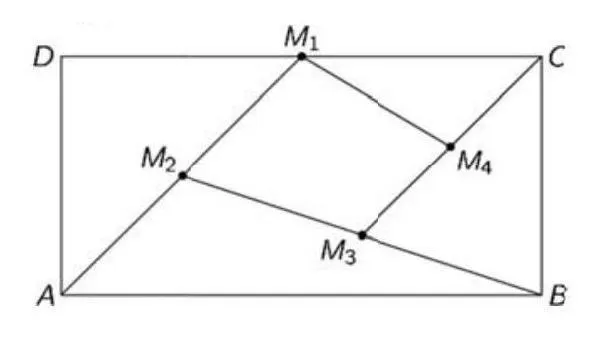

Input: Please answer the question and provide the correct option letter, e.g., A, B, C, D, at the end.
Question: Find $m\angle H$
Choices:
(A) 97
(B) 102
(C) 107
(D) 122

Answer:

<thinking>
Okay, so I'm trying to figure out the measure of angle H in this geometry problem. The image shows a rectangle ABCD with points M1, M2, M3, and M4 inside it. The diagonals AC and BD intersect at point M, which is the midpoint of both diagonals. The image also shows that M1, M2, M3, M4 are midpoints of the sides of the rectangle.

First, I remember that in a rectangle, the diagonals are equal in length and they bisect each other. So, point M is the midpoint of both AC and BD. That means AM = MC and BM = MD.

Now, the image shows that M1, M2, M4, and M3 are midpoints of the sides. So, M1 is the midpoint of AB, M2 is the midpoint of BC, M3 is the midpoint of CD, and M4 is the midpoint of DA.

I think the key here is to recognize that connecting these midpoints forms another shape inside the rectangle.

In [5]:
import os
import json
os.environ["TOKENIZERS_PARALLELISM"] = "true"


cot_prompt = "SYSTEM: You are a helpful assistant. When the user asks a question, your response must include two parts: first, the reasoning process enclosed in <thinking>...</thinking> tags, then the final answer enclosed in <answer>...</answer> tags. The critical answer or key result should be placed within \\boxed{}.\n"
# And your input message should be like this:
question = "Please answer the question and provide the correct option letter, e.g., A, B, C, D, at the end.\nQuestion: Find $m\\angle H$\nChoices:\n(A) 97\n(B) 102\n(C) 107\n(D) 122"
messages = [
    {
        "role": "HUMAN",
        "content": [
            {"type": "image", "image": "figures/cases/reasoning.png"},
            {"type": "text", "text": cot_prompt + question},
        ],
    },
]

from IPython.utils import io
with io.capture_output() as captured: # used to suppress output inside the function
    output_text = generate(messages)

from IPython.display import display, Image
display(Image("figures/cases/reasoning.png"))
print(f"Input: {question}\n")
print("Answer:\n")
print(output_text)

### 🎥 Video QA Example

In [6]:
# video qa
messages = [
    {
        "role": "HUMAN",
        "content": [
            {"type": "video", "video": "figures/cases/yoga.mp4", "max_frames": 64, "sample": "uniform"},
            {"type": "text", "text": "What is the woman doing?"},
        ],
    },
]

from IPython.utils import io
with io.capture_output() as captured: # used to suppress output inside the function
    output_text = generate(messages)

import io
import base64
from IPython.display import HTML

video = io.open('figures/cases/yoga.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>
             <p>What is the woman doing in the video?</p>
             <p>Answer: {1}</p>
          '''.format(encoded.decode('ascii'), output_text))


2025-07-18 17:30:46,582 - bailingmm_utils - INFO - decord:  video_path='figures/cases/yoga.mp4', total_frames=300, video_fps=30.0, time=0.043s


### 💬 Multi-turn Conversation

In [7]:
# multi-turn chat
messages = [
    {
        "role": "HUMAN",
        "content": [
            {"type": "text", "text": "中国的首都是哪里？"},
        ],
    },
    {
        "role": "ASSISTANT",
        "content": [
            {"type": "text", "text": "北京"},
        ],
    },
    {
        "role": "HUMAN",
        "content": [
            {"type": "text", "text": "它有哪些著名景点？列出3个。"},
        ],
    },
]

from IPython.utils import io
with io.capture_output() as captured: # used to suppress output inside the function
    output_text = generate(messages)

print("Human: 中国的首都是哪里？")
print("Assistant: 北京")
print("Human: 它有哪些著名景点？列出3个。\n")

print("Answer:")
print(output_text)

Human: 中国的首都是哪里？
Assistant: 北京
Human: 它有哪些著名景点？列出3个。

Answer:
故宫、长城、颐和园。


### 🔊 Audio Tasks

For detailed usage for ASR, SpeechQA, and TTS tasks, please refer to `test_audio_tasks.py`

In [9]:
from hyperpyyaml import load_hyperpyyaml
from audio_detokenizer.cli.frontend import TTSFrontEnd
from modeling_bailing_talker import AudioDetokenizer

model_path = 'inclusionAI/Ming-Lite-Omni'

spk_info = {
        'luna': torch.load('data/spks/luna_v2.pt'),
        'eng': torch.load('data/spks/eng_v2.pt'),
    }

with open(f"{model_path}/talker/audio_detokenizer_stream.yaml", "r") as f:
    configs = load_hyperpyyaml(f)

audio_detokenizer = AudioDetokenizer(
    f"{model_path}/talker/audio_detokenizer_stream.yaml",
    flow_model_path=f"{model_path}/talker/flow_stream.pt",
    hifigan_model_path=f"{model_path}/talker/hift_v2.pt",
    spk_info=spk_info,
)
# new mel
audio_frontend = TTSFrontEnd(
    configs["feat_extractor"],
    f"{model_path}/talker/campplus.onnx",
    f"{model_path}/talker/speech_tokenizer_v1.onnx",
)

2025-07-18 17:32:02,544 - root - INFO - input frame rate=50
2025-07-18 17:32:17,402 - root - INFO - input frame rate=50


In [10]:
# ASR
from IPython.display import display, Audio
from test_audio_tasks import generate
print("Testing ASR...")
messages = [
    {
        "role": "HUMAN",
        "content": [
            {
                "type": "text",
                "text": "Please recognize the language of this speech and transcribe it. Format: oral.",
            },
            {"type": "audio", "audio": "data/wavs/BAC009S0915W0283.wav"},
        ],
    },
]

output_text = generate(messages=messages, processor=processor, model=model)

print("Input audio:")
display(Audio('data/wavs/BAC009S0915W0283.wav'))
print(f"Output text: {output_text}")

Testing ASR...
Chinese	也正是看中了中国消费者的消费潜力
Generate time: 0.66s
Input audio:


Output text: Chinese	也正是看中了中国消费者的消费潜力


In [11]:
# Speech QA
from test_audio_tasks import generate_e2e

print("Testing Speech QA...")
messages = [
    {
        "role": "HUMAN",
        "content": [
            {"type": "audio", "audio": "data/wavs/speechQA_sample.wav"},
        ],
    },
]

GENERATION_CONFIG = {
    "output_hidden_states": True,
    "return_dict_in_generate": True,
    "no_repeat_ngram_size": 10,
}
output_audio_path = 'data/wavs/out_speechqa.wav'

text_response, audio_wave = generate_e2e(
    messages=messages,
    processor=processor,
    model=model,
    audio_detokenizer=audio_detokenizer,
    output_audio_path=output_audio_path,
    spk_info=spk_info,
    generation_config=GENERATION_CONFIG,
    stream=False,
)

print("Input audio:")
display(Audio('data/wavs/speechQA_sample.wav'))

print(f"Output audio: {text_response}")
display(Audio(output_audio_path))

Testing Speech QA...


From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
We detected that you are passing `past_key_values` as a tuple of tuples. This is deprecated and will be removed in v4.47. Please convert your cache or use an appropriate `Cache` class (https://huggingface.co/docs/transformers/kv_cache#legacy-cache-format)


Generate time: 9.93s
Input audio:


Output audio: 你好！我是一个名为百灵原生多模态的多模态模型，由蚂蚁集团研发。我可以回答你的问题，帮助你解决疑惑。请问有什么我可以帮助你的吗？。


In [12]:
# zero-shot TTS
from test_audio_tasks import generate_tts

output_audio_path = 'data/wavs/out_tts.wav'
# TTS Generation
print("Testing TTS...")
tts_text="这是一条测试语句。"
tts_wave = generate_tts(
    tts_text=tts_text,
    prompt_text="感谢你的认可。",
    prompt_wav_path="data/spks/prompt.wav",
    audio_frontend=audio_frontend,
    model=model,
    audio_detokenizer=audio_detokenizer,
    output_audio_path=output_audio_path,
    stream=False,
)

print(f"input text: {tts_text}")
print(f"Output audio:")
display(Audio(output_audio_path))

Testing TTS...


2025-07-18 17:32:47,750 - root - INFO - for last sentence


Generate time: 6.00s
input text: 这是一条测试语句。
Output audio:


### 🎨 Image Generation & Editing

Ming-omni natively supports image generation and image editing. To use this function, you only need to add the corresponding parameters in the generate function.

In [13]:
# Image generation mode currently limits the range of input pixels.
gen_input_pixels = 451584
processor.max_pixels = gen_input_pixels
processor.min_pixels = gen_input_pixels

def generate_image(messages, processor, model, **image_gen_param):
    text = processor.apply_chat_template(messages, add_generation_prompt=True)
    image_inputs, video_inputs, audio_inputs = processor.process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        audios=audio_inputs,
        return_tensors="pt",
    ).to(model.device)

    for k in inputs.keys():
        if k == "pixel_values" or k == "pixel_values_videos" or k == "audio_feats":
            inputs[k] = inputs[k].to(dtype=torch.bfloat16)
    
    image = model.generate(
        **inputs,
        image_gen=True,
        **image_gen_param,
    )
    return image

Text-to-image generation

[Hyper-Param]: 
   do_img_cfg: False 
   guidance_scale: 5.0 
   img_cfg: 1.0 
   cfg_mode: 1


100%|██████████| 30/30 [00:02<00:00, 12.52it/s]


Instruction: Draw a beautiful girl with short black hair and red dress.


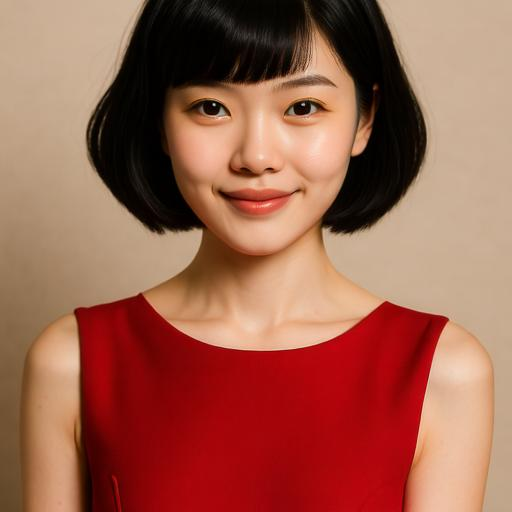

In [14]:
# Image generation mode currently limits the range of input pixels.
gen_input_pixels = 451584
processor.max_pixels = gen_input_pixels
processor.min_pixels = gen_input_pixels

messages = [
    {
        "role": "HUMAN",
        "content": [
            {"type": "text", "text": "Draw a beautiful girl with short black hair and red dress."},
        ],
    }
]

text = processor.apply_chat_template(messages, add_generation_prompt=True)
image_inputs, video_inputs, audio_inputs = processor.process_vision_info(messages)


inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    audios=audio_inputs,
    return_tensors="pt",
).to(model.device)

for k in inputs.keys():
    if k in ["pixel_values", "pixel_values_videos", "audio_feats", "pixel_values_reference"]:
        inputs[k] = inputs[k].to(dtype=torch.bfloat16)

# set `image_gen=True` to enable image generation
image = model.generate(
    **inputs,
    image_gen=True,
)

image.save("figures/cases/t2i.jpg")

print("Instruction: Draw a beautiful girl with short black hair and red dress.")
from IPython.display import display, Image
display(Image("figures/cases/t2i.jpg"))

Image Editing

[Hyper-Param]: 
   do_img_cfg: False 
   guidance_scale: 5.0 
   img_cfg: 1.0 
   cfg_mode: 1


100%|██████████| 30/30 [00:04<00:00,  7.35it/s]


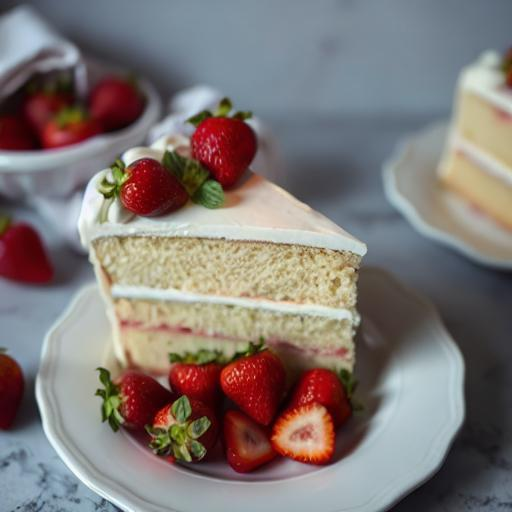

Instruction: add candles in the middle

Output image:


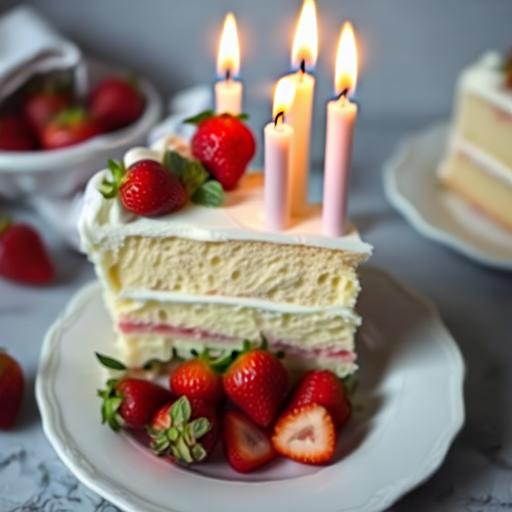

In [15]:
messages = [
    {
        "role": "HUMAN",
        "content": [
            {"type": "image", "image": "figures/cases/cake.jpg"},
            {"type": "text", "text": "add candles in the middle"},
        ],
    },
]

text = processor.apply_chat_template(messages, add_generation_prompt=True)
image_inputs, video_inputs, audio_inputs = processor.process_vision_info(messages)


inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    audios=audio_inputs,
    return_tensors="pt",
).to(model.device)

for k in inputs.keys():
    if k in ["pixel_values", "pixel_values_videos", "audio_feats", "pixel_values_reference"]:
        inputs[k] = inputs[k].to(dtype=torch.bfloat16)

image = model.generate(
    **inputs,
    image_gen=True,
)
image.save("figures/cases/cake_edit.jpg")

from IPython.display import display, Image
display(Image("figures/cases/cake.jpg"))
print("Instruction: add candles in the middle\n")

print("Output image:")
display(Image("figures/cases/cake_edit.jpg"))
     